# Acceptance model for B02JpsiKS

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import ROOT
from ROOT import (RooArgSet,
                  RooCategory,
                  RooRealVar,
                  RooDataSet,
                  RooPlot,
                  RooFit,
                  RooStats,
                  RooArgList,
                  RooFormulaVar)

from ROOT import (TFile, 
                  TH1D, 
                  TH2D, 
                  TCanvas, 
                  gStyle, 
                  TLine, 
                  TTree)

import math
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from root_pandas import read_root
import pandas as pd
            
sys.path.append('/home/vmueller/repos/')
from dopy.doroot.root_utils import read_roodataset_from_tree, plot_pulls, build_tchain_from_files
from dopy.doplot.plotting import Plotter, Plot
import dopy.doroot.rootnotes 
from dopy.doplot.selection import add_log_to_dataframe, add_max_to_dataframe, add_min_to_dataframe

In [2]:
dataset_dir = '/fhgfs/users/chasenberg/data/2015_2016_merged/jpsimumuks'
 
#new dataset
dataset_file_name= 'Bd2JpsiKS_final_sw.root'
dataset_tree_name = 'Bd2JpsiKS'
dataset_file_name = os.path.join(dataset_dir, dataset_file_name) 

In [3]:
dataset_file = TFile(dataset_file_name)
ROOT.SetOwnership(dataset_file, False)

dataset_tree = dataset_file.Get(dataset_tree_name)
ROOT.SetOwnership(dataset_tree, False) 

In [112]:
obsTime     = RooRealVar('B0_FitPVConst_tau_flat', 'obsTime', 0,0.0002, 0.01, 'ns')
obsTimeErr = RooRealVar("B0_FitPVConst_tauErr_flat", "obsTimeErr", 0,-0.001,0.001, "ns")
signal_sw  = RooRealVar("signal_sw", "signal_sw",0 ,-100000,1000000000)
mass = RooRealVar("B0_FitDaughtersConst_M_flat", "m_{J/psi K_{S}^{0}}", 5280,5250, 5310, "MeV")


ROOT.SetOwnership(obsTime, False)
ROOT.SetOwnership(obsTimeErr, False)
ROOT.SetOwnership(signal_sw, False)

data = ROOT.TFile(dataset_file_name)
tree_data = data.Get('Bd2JpsiKS') 
tree_data.GetEntries()
ntupleVarSet =  RooArgSet(obsTime,obsTimeErr,mass)#,mass)#,signal_sw)
data = RooDataSet('data','data',ntupleVarSet,RooFit.Import(tree_data))#, RooFit.WeightVar("signal_sw"))
ROOT.SetOwnership(data,False)

print('Number of entries: '+ str(data.numEntries()))

Number of entries: 125484


In [113]:
subdir = '/home/chasenberg/plots/acceptance'
plot_dir    = os.path.join(subdir, 'plots')
results_dir = os.path.join(subdir, 'results')
plot_file   = os.path.join(plot_dir, 'all_plots.pdf')

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

### Build acceptance model

In [114]:
from ROOT import gSystem
gSystem.Load("libRooFit.so")
gSystem.Load("/home/vmueller/repos/dopy/dolib/acceptances/libAcceptances")

1

In [115]:
from ROOT import RooCubicSplineFun
from ROOT import RooResolutionModel 

In [116]:
from ROOT import std
knots = std.vector("double")(7)
knots[0]=(obsTime.getMin()) # 0.0
knots[1]=(0.00025)
knots[2]=(0.0004)
knots[3]=(0.001)
knots[4]=(0.003)
#knots[4]=(0.005)
knots[5]=(0.008)
knots[6]=(obsTime.getMax()) # 18.0

In [117]:
print(obsTime.getMin(),obsTime.getMax(),len(knots))

0.0002 0.01 7


In [118]:
knotlist = RooArgList("knotlist")
ROOT.SetOwnership(knotlist, False)

# This is needed because 2 extra coefficients are needed
# (assert statement)
for i in range(0,len(knots)+1): # len(knots)+2
    binname = "parTimeAccCSpline" + str(i)
    bintitle = "h_{" + str(i) + "}"
    var = RooRealVar(binname, bintitle,0.1*i,3)
    print(var.getVal())
    #print(str(var.GetName()))
    ROOT.SetOwnership(var, False)
    knotlist.add(var)
    
knotlist.add(knotlist[len(knots)])  

accspline = RooCubicSplineFun("accspline", "Spline Acceptance", obsTime, knots, knotlist)
ROOT.SetOwnership(accspline, False)
#RooCubicSplineFun()

1.5
1.55
1.6
1.65
1.7
1.75
1.8
1.85


In [119]:
knotlist

<ROOT.RooArgList object ("knotlist") at 0xb265080>

### Build resolution model

In [120]:
from ROOT import RooGaussEfficiencyModel
from ROOT import RooEffResAddModel

In [121]:
'''
############################################################################################################
############################################################################################################

parResCondMean  = RooRealVar('parResCondMean', 'parResCondMean', 1.6327315410791243e-07,1.6327315410791243e-07,1.6327315410791243e-07)
ROOT.SetOwnership(parResCondMean, False)

parResCond_a_1 = RooRealVar('parResCond_a_1', 'parResCond_a_1', 0.000957,0.000957,0.000957)
ROOT.SetOwnership(parResCond_a_1, False)
parResCond_b_1 = RooRealVar('parResCond_b_1', 'parResCond_b_1', 3.400373600920488e-05,3.400373600920488e-05,3.400373600920488e-05)
ROOT.SetOwnership(parResCond_b_1, False)


parResCond_a_2 = RooRealVar('parResCond_a_2', 'parResCond_a_2',0.00136,0.00136,0.00136)
ROOT.SetOwnership(parResCond_a_2, False)
parResCond_b_2 = RooRealVar('parResCond_b_2', 'parResCond_b_2',7.319592857798117e-05,7.319592857798117e-05,7.319592857798117e-05)
ROOT.SetOwnership(parResCond_b_2, False)


parResCond_a_3 = RooRealVar('parResCond_a_3', 'parResCond_a_3', 0,0,0)
ROOT.SetOwnership(parResCond_a_3, False)
parResCond_b_3 = RooRealVar('parResCond_b_3', 'parResCond_b_3', 0.0003164230064816959,0.0003164230064816959,0.0003164230064816959)
ROOT.SetOwnership(parResCond_b_3, False)





#Definition and calculation of sigma's, related linearly on the decaytime error from the ntuple 
parResCondSigma_1 = RooFormulaVar('parResCondSigma_1', '@0*@1+@2', RooArgList(parResCond_a_1, obsTimeErr, parResCond_b_1))
ROOT.SetOwnership(parResCondSigma_1, False)

parResCondSigma_2 = RooFormulaVar('parResCondSigma_2', '@0*@1+@2', RooArgList(parResCond_a_2, obsTimeErr, parResCond_b_2))
ROOT.SetOwnership(parResCondSigma_2, False)

parResCondSigma_3 = RooFormulaVar('parResCondSigma_3', '@0*@1+@2', RooArgList(parResCond_a_3, obsTimeErr, parResCond_b_3))
ROOT.SetOwnership(parResCondSigma_3, False)
 


#Fractions of particular PDF's  
parResCondFrac_1 = RooRealVar('parResCondFrac_1', 'parResCondFrac_1', 0.7071340952378221,0.7071340952378221,0.7071340952378221)
ROOT.SetOwnership(parResCondFrac_1, False)
parResCondFrac_2 = RooRealVar('parResCondFrac_2', 'parResCondFrac_2', 0.28485890496886224,0.28485890496886224,0.28485890496886224)
ROOT.SetOwnership(parResCondFrac_2, False)
 

pdfEffModel1 = RooGaussEfficiencyModel('pdfEffModel1', 'pdfEffModel1', obsTime, accspline, parResCondMean, parResCondSigma_1)
ROOT.SetOwnership(pdfEffModel1, False)
pdfEffModel2 = RooGaussEfficiencyModel('pdfEffModel2', 'pdfEffModel2', obsTime, accspline, parResCondMean, parResCondSigma_2)
ROOT.SetOwnership(pdfEffModel2, False)
pdfEffModel3 = RooGaussEfficiencyModel('pdfEffModel3', 'pdfEffModel3', obsTime, accspline, parResCondMean, parResCondSigma_3)
ROOT.SetOwnership(pdfEffModel3, False) 
 
pdfRes = RooEffResAddModel('pdfRes', 'pdfRes', RooArgList(pdfEffModel1,pdfEffModel2, pdfEffModel3), RooArgList(parResCondFrac_1, parResCondFrac_2))
ROOT.SetOwnership(pdfRes, False)
pdfRes.Print('t')

'''

"\n############################################################################################################\n############################################################################################################\n\nparResCondMean  = RooRealVar('parResCondMean', 'parResCondMean', 1.6327315410791243e-07,1.6327315410791243e-07,1.6327315410791243e-07)\nROOT.SetOwnership(parResCondMean, False)\n\nparResCond_a_1 = RooRealVar('parResCond_a_1', 'parResCond_a_1', 0.000957,0.000957,0.000957)\nROOT.SetOwnership(parResCond_a_1, False)\nparResCond_b_1 = RooRealVar('parResCond_b_1', 'parResCond_b_1', 3.400373600920488e-05,3.400373600920488e-05,3.400373600920488e-05)\nROOT.SetOwnership(parResCond_b_1, False)\n\n\nparResCond_a_2 = RooRealVar('parResCond_a_2', 'parResCond_a_2',0.00136,0.00136,0.00136)\nROOT.SetOwnership(parResCond_a_2, False)\nparResCond_b_2 = RooRealVar('parResCond_b_2', 'parResCond_b_2',7.319592857798117e-05,7.319592857798117e-05,7.319592857798117e-05)\nROOT.SetOwnership(pa

In [122]:
from ROOT import RooGaussian, RooAddPdf
from ROOT import RooGaussModel
from ROOT import RooAddModel
from ROOT import RooSimultaneous
from ROOT import (RooArgSet,
                  RooCategory,
                  RooRealVar,
                  RooDataSet,
                  RooPlot,
                  RooFit,
                  RooStats,
                  RooArgList,
                  RooFormulaVar)

from ROOT import (TFile, 
                  TH1D, 
                  TH2D, 
                  TCanvas, 
                  gStyle, 
                  TLine, 
                  TTree)

#Build and add two Gaussians for describing the central distribution
mean_1 = RooRealVar("mean", "mean",  0.000000169550, 0.000000169550, 0.000000169550)

sigma_1 = RooRealVar("sigma_1", "sigma_1", 0.0000354456,0.0000354456,0.0000354456)
sigma_2 = RooRealVar("sigma_2", "sigma_2", 0.0000796985,0.0000796985,0.0000796985)
sigma_3 = RooRealVar("sigma_3", "sigma_3", 0.488917,0.488917,0.488917)


signal_1 = RooGaussian("signal_1","signal_1",obsTime,mean_1,sigma_1)
signal_2 = RooGaussian("signal_2","signal_2",obsTime,mean_1,sigma_2)
signal_3 = RooGaussian("signal_3","signal_3",obsTime,mean_1,sigma_3)

sig1frac = RooRealVar("sig1frac","fraction of component 2 in signal", 0.755166, 0.755166, 0.755166) 
sig2frac = RooRealVar("sig2frac","fraction of component 1 in signal", 0.240672,0.240672,0.240672) 


ROOT.SetOwnership(mean_1,False)
ROOT.SetOwnership(sigma_1,False)
ROOT.SetOwnership(sigma_2,False)
ROOT.SetOwnership(sigma_3,False)
ROOT.SetOwnership(signal_1,False)
ROOT.SetOwnership(signal_2,False)
ROOT.SetOwnership(signal_3,False)
ROOT.SetOwnership(sig2frac,False)
ROOT.SetOwnership(sig1frac,False)

pdfEffModel1 = RooGaussEfficiencyModel('pdfEffModel1', 'pdfEffModel1', obsTime, accspline, mean_1, sigma_1)
ROOT.SetOwnership(pdfEffModel1, False)
pdfEffModel2 = RooGaussEfficiencyModel('pdfEffModel2', 'pdfEffModel2', obsTime, accspline, mean_1, sigma_2)
ROOT.SetOwnership(pdfEffModel2, False)
pdfEffModel3 = RooGaussEfficiencyModel('pdfEffModel3', 'pdfEffModel3', obsTime, accspline, mean_1, sigma_3)
ROOT.SetOwnership(pdfEffModel3, False) 

pdfRes = RooEffResAddModel('pdfRes', 'pdfRes', RooArgList(pdfEffModel1,pdfEffModel2, pdfEffModel3), RooArgList(sig1frac, sig2frac))
ROOT.SetOwnership(pdfRes, False)
pdfRes.Print('t') 

### Build RooDecay

In [123]:
from ROOT import RooDecay
from ROOT import RooSimultaneous

parTimeTau = RooRealVar("parTimeTau", "#it{#tau}", 0.001520)#, 1.520, 1.520) #1.520 +- 0.004ps

ROOT.SetOwnership(parTimeTau, False)

pdfDecayTime = RooDecay("pdfDecayTime", "pdfDecayTime", obsTime, parTimeTau, pdfRes, RooDecay.SingleSided)

ROOT.SetOwnership(pdfDecayTime, False)

In [124]:
results_dir = '/home/chasenberg/plots/resolution/results/'

parameters_file_name  = 'params_cond.txt'
parameters_init_name  = parameters_file_name.replace('.txt', '_init.txt')
parameters_final_name = parameters_file_name.replace('.txt', '_final.txt')

if os.path.exists(os.path.join(results_dir, parameters_init_name)):
    print('INFO: Reading parameters from configfile '  + os.path.join(results_dir, parameters_init_name), flush=True)
    data_model_cond.getParameters(data).readFromFile(os.path.join(results_dir, parameters_init_name))
else:
    print('INFO: configfile... '  + os.path.join(results_dir, parameters_init_name) + ' does not exist', flush=True)
    
cond_argset = RooArgSet(obsTimeErr)    


fit_result = pdfDecayTime.fitTo(data, 
                                    RooFit.NumCPU(6),
                                    RooFit.Minimizer('Minuit','minimize'),
                                    RooFit.Hesse(True),
                                    RooFit.Save(True),
                                    RooFit.ConditionalObservables(cond_argset)) 

if fit_result:
    fit_result.Print('v')
    fit_result.correlationMatrix().Print('v')
    if fit_result.status()==0:
        print('INFO: Fit converged')
    else:
        print('INFO: Status '+str(fit_result.status()))
    print('INFO: Fit complete', flush=True)
else:
    print('ERROR: There is no fitresult', flush=True)
 
final_params_file = os.path.join(results_dir, parameters_final_name)
pdfRes.getParameters(data).writeToFile(final_params_file)

INFO: configfile... /home/chasenberg/plots/resolution/results/params_cond_init.txt does not exist
INFO: Fit converged
INFO: Fit complete


### Plot RooDecay

INFO: Start plotting
INFO: Finish plotting


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: canvas
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


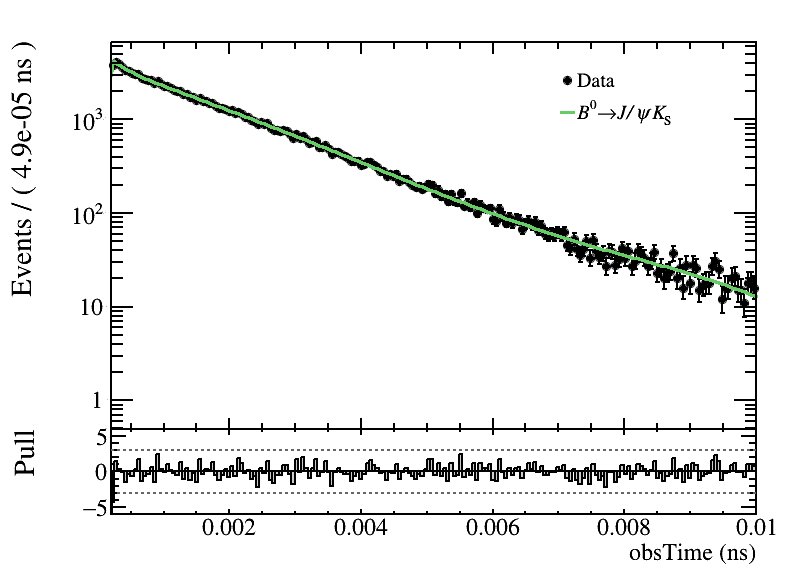

In [125]:
print('INFO: Start plotting', flush=True)
from ROOT import TColor
from root_utils.lhcb_style import set_lhcb_style # Set basic LHCb plot style
set_lhcb_style()   

decay_set  = ROOT.RooArgSet(pdfDecayTime.getComponents().find('pdfDecayTime'))
ROOT.SetOwnership(decay_set, False)

# Prepare frame
canvas = TCanvas('canvas', 'canvas', 1000, 600)
ROOT.SetOwnership(canvas, False)

plot_frame = obsTime.frame(ROOT.RooFit.Range(0.0002, 0.01), ROOT.RooFit.Bins(200))
ROOT.SetOwnership(plot_frame, False)

data.plotOn(plot_frame, ROOT.RooFit.Name('data'))
pdfDecayTime.plotOn(plot_frame, RooFit.ProjWData(RooArgSet(obsTimeErr), data, True), RooFit.LineColor(410), ROOT.RooFit.Name('decay_fit'))

### Add additional informations to the plot
text_size = 0.05
# Create TLegend
legend = ROOT.TLegend(0.7, 0.7, 0.80, 0.85)
#legend = ROOT.TLegend(0.7, 0.30, 0.80, 0.5)
ROOT.SetOwnership(plot_frame, False)
legend.AddEntry(plot_frame.findObject('data'), 'Data', 'p')
legend.AddEntry(plot_frame.findObject('decay_fit'), '#it{B}^{0}#rightarrow#it{J/#psi}#it{K}_{#kern[-0.3]{S}}', 'l')
legend.SetTextSize(text_size)

# Plot pulls
plotname = 'decay_time_mc'
can, _ = plot_pulls(plotname, plot_frame, drawables=[legend], save_path= subdir + '/plots/', logy=True)#, logy=True
print('INFO: Finish plotting', flush=True)
can

## Plotting Acceptance

In [126]:
nbins = 50
time_min = obsTime.getMin()
time_max = obsTime.getMax()

from ROOT import TH1D
hist_obsTime = TH1D('hist_obsTime', 'hist_obsTime', nbins, time_min, time_max)
ROOT.SetOwnership(hist_obsTime, False)

for i in range(data.numEntries()):
    hist_obsTime.Fill(data.get(i).getRealValue('obsTime'))
    
canvas = TCanvas('canvas', 'canvas', 1000, 600)
ROOT.SetOwnership(canvas, False)
hist_obsTime.Sumw2()
hist_obsTime.Draw()
#canvas   

TFile::Append:0: RuntimeWarning: Replacing existing TH1: hist_obsTime (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: hist_obsTime (Potential memory leak).
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: canvas


In [127]:
from ROOT import TRandom3

expo = TRandom3(1337)
hist_exp = TH1D('hist_exp', 'hist_exp', nbins, time_min, time_max)

for i in range(0,nbins):
    hist_exp.SetBinContent(i,data.numEntries()*np.exp(-(time_min+(i+0.5)*(time_max-time_min)/nbins)/1.520))

hist_exp.Sumw2()
hist_exp.Draw()
#canvas

TFile::Append:0: RuntimeWarning: Replacing existing TH1: hist_exp (Potential memory leak).


In [128]:
hist_obsTime.Sumw2()
hist = TH1D(hist_obsTime)
hist.Divide(hist_exp)
norm_divided = hist.GetSumOfWeights()
hist.Scale(1/100)
hist.Draw()
#canvas

TH1D::Sumw2:0: RuntimeWarning: Sum of squares of weights structure already created


In [129]:
acc_int = accspline.createIntegral(RooArgSet(obsTime))
print(acc_int.getVal())
scale_bin = (time_max-time_min)/nbins
scale = (1/acc_int.getVal())*scale_bin
print(scale)

0.018070290796177006
0.010846532698935107


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: canvas_scaled


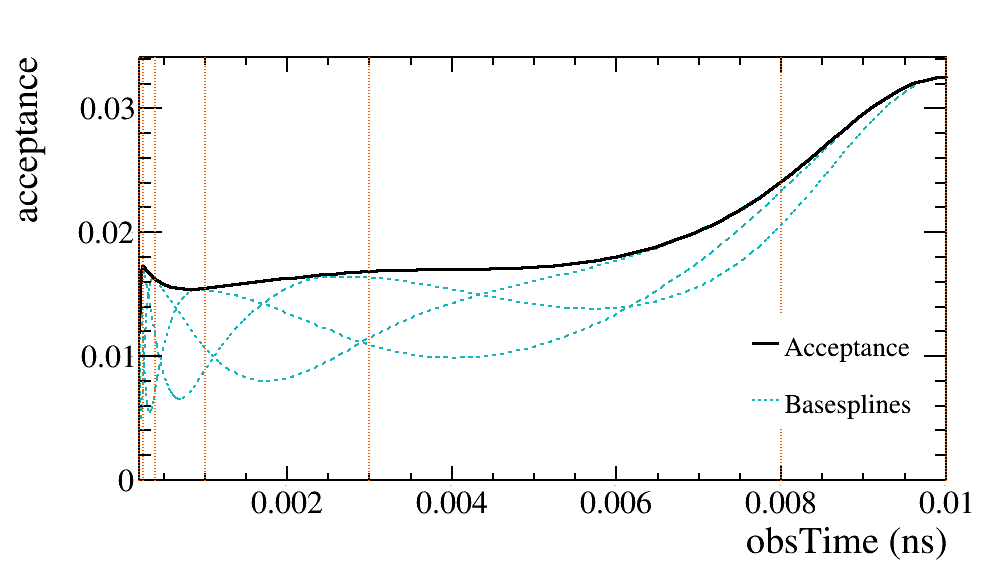

In [130]:
from ROOT import TLine
from ROOT import TLegend

canvas_scaled = TCanvas('canvas_scaled', 'canvas_scaled', 1000, 600)
time_frame = obsTime.frame()
accspline.plotOn(time_frame, RooFit.Normalization(scale),RooFit.LineColor(1))
#time_frame.addTH1(hist)

coeffs = accspline.coefficients()
basesplines = []
lines = []
baselist = RooArgList()

for i,knot in enumerate(knots):
    baselist = coeffs.snapshot()
    for j in range(baselist.getSize()):
        if j==i:
            baselist[i] = coeffs[i] #RooRealVar('blub_'+str(i)+'_'+str(j), 'blub_'+str(i)+'_'+str(j), 1.0)#
            ROOT.SetOwnership(baselist[i], False)
        else:
            baselist[i].setVal(0.0)   
    baselist.Print()        
    basespline = RooCubicSplineFun('csplines'+str(i),'csplines'+str(i), obsTime, knots, baselist)
    basesplines.append(basespline)
    basespline.plotOn(time_frame, RooFit.Normalization(scale), RooFit.LineColor(226), RooFit.LineStyle(2), RooFit.LineWidth(2), RooFit.Name('basespline'))
    line = TLine(knot, 0, knot, time_frame.GetMaximum())
    line.SetLineColor(96)
    line.SetLineStyle(3)
    lines.append(line)

accspline.plotOn(time_frame, RooFit.Normalization(scale),RooFit.LineColor(1), RooFit.Name('accspline'))
time_frame.GetYaxis().SetTitle('acceptance')
time_frame.Draw()
for line in lines:
    line.Draw()
    
### Add additional informations to the plot
text_size = 0.05
# Create TLegend
legend = ROOT.TLegend(0.75, 0.25, 0.90, 0.45)
#legend.AddEntry(time_frame.findObject('hist_obsTime'), 'MC #it{B}^{0}#rightarrow#it{#psi}(2S)#it{K}_{#kern[-0.3]{S}}', 'p')
legend.AddEntry(time_frame.findObject('accspline'), 'Acceptance', 'l')
legend.AddEntry(time_frame.findObject('basespline'), 'Basesplines', 'l')
legend.SetTextSize(text_size) 
legend.Draw()
canvas_scaled.SaveAs('/home/chasenberg/plots/acceptance/acceptance_mc.pdf') 
canvas_scaled 

In [131]:
canvas_scaled.SaveAs(subdir + '/plots/'+'acceptance.pdf')